In [1]:
import os
import json
from datasets import load_dataset



/Users/szymon/Documents/projekciki/Essay_LMM_Distillation/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from chart images.
Your task is to analyze the provided chart image and title, then respond with IELTS Band 9 essay about the data.
You use sofisticated vocabulary and correct grammar, moreover you use synonyms and you do not repeat words."""

In [12]:
def format_data(sample):
    return [
        {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": system_message
                }
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": sample['title'] ,
                }
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": sample["essay"]
                }
            ],
        },
    ]

In [2]:
!pip install  -U -q transformers trl datasets bitsandbytes peft accelerate

In [3]:
!pip install -q wheel

In [26]:
!pip install -q tensorboardX

In [4]:
!pip install -q wheel flash-attn --no-build-isolation

In [13]:
from huggingface_hub import login
hub_key=os.getenv('HUGGINGFACE_HUB')
login(token=hub_key)

In [14]:
dataset = load_dataset("szymmon/SmolVLM_Essay_Database")

shuffled_dataset = dataset['train'].shuffle(seed=42)

# Simple 70-15-15 split
total_size = len(shuffled_dataset)
train_dataset, test_dataset, eval_dataset = shuffled_dataset.select(range(int(0.7*total_size))), shuffled_dataset.select(range(int(0.7*total_size), int(0.85*total_size))), shuffled_dataset.select(range(int(0.85*total_size), total_size))


Generating train split: 100%|██████████| 3475/3475 [00:00<00:00, 12819.52 examples/s]


## Format for chatbot structure

In [15]:
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

In [18]:
train_dataset[544]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and title, then respond with IELTS Band 9 essay about the data.\nYou use sofisticated vocabulary and correct grammar, moreover you use synonyms and you do not repeat words.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=800x557>},
   {'type': 'text',
    'text': 'Number of stores of Nordstrom worldwide as of 2020 , by type\n'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': "The bar chart illustrates the number of Nordstrom stores worldwide as of 2020, categorized by type, specifically full-price and off-price stores.\n\nThe chart reveals a significant disparity in the number of full-price versus off-price Nordstrom stores. Specifically, there are approximately 136 full-price stores, which 

In [17]:
print(train_dataset[1][2]['content'][0]['text'])

The bar chart illustrates the annual salaries of the ten best-paid French sportsmen in 2018, measured in millions of euros.

Antoine Griezmann leads the ranking with an annual salary of 33 million euros, significantly higher than the second-highest earner, Kylian Mbappé, who earns 24.7 million euros. Paul Pogba and Karim Benzema follow closely, with salaries of 22.1 million euros and 22 million euros respectively.

Nicolas Batum and Rudy Gobert, both basketball players, earn 20.9 million euros and 20.6 million euros respectively. Ousmane Dembélé, another football player, earns 19.1 million euros. Joakim Noah and Evan Fournier, also basketball players, earn 17.5 million euros and 15.2 million euros respectively. Franck Ribéry, the last on the list, earns 14.3 million euros.

Overall, football players dominate the top of the list, with Antoine Griezmann and Kylian Mbappé being the highest earners. Basketball players also feature prominently, with Nicolas Batum and Rudy Gobert earning sub

In [19]:
print(train_dataset[1][1]['content'][1]['text'])

Ranking of the ten best-paid French sportsmen in 2018  ( in million euros )



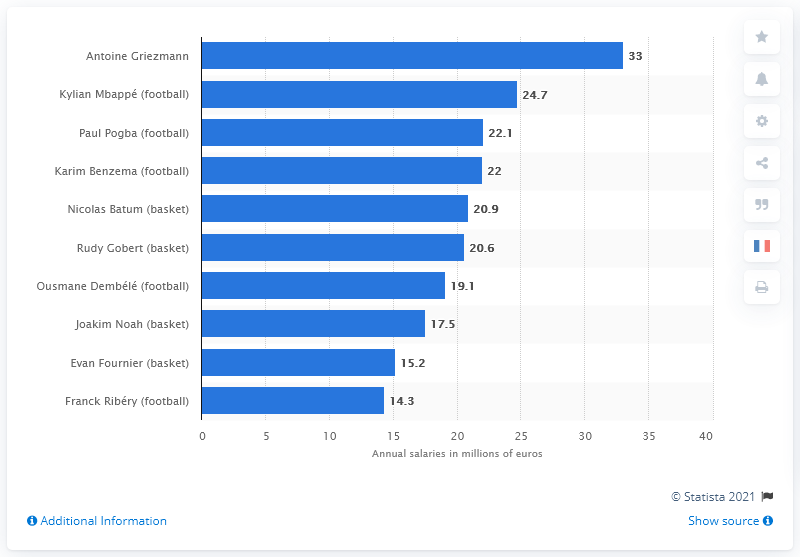

In [17]:
train_dataset[1][1]['content'][0]['image']

## Load model

In [18]:
import torch
from transformers import Idefics3ForConditionalGeneration, AutoProcessor

model_id = "HuggingFaceTB/SmolVLM-Instruct"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [19]:
def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample[1:2],  # Use the sample without the system message
        add_generation_prompt=True
    )

    image_inputs = []
    image = sample[1]['content'][0]['image']
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image_inputs.append([image])

    # Prepare the inputs for the model
    model_inputs = processor(
        #text=[text_input],
        text=text_input,
        images=image_inputs,
        return_tensors="pt",
    ).to(device)  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [70]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

GPU allocated memory: 4.71 GB
GPU reserved memory: 9.71 GB


## Fine-Tuning

In [71]:
from transformers import BitsAndBytesConfig

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    _attn_implementation="flash_attention_2",
)
processor = AutoProcessor.from_pretrained(model_id)

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


In [72]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],
    use_dora=True,
    init_lora_weights="gaussian"
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 11,269,248 || all params: 2,257,542,128 || trainable%: 0.4992


In [73]:
from trl import SFTConfig

training_args = SFTConfig(
    output_dir="smolvlm-instruct-trl-sft-ChartQA_increased_batch",
    num_train_epochs=1,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6,
    gradient_accumulation_steps=6,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=25,
    evaluation_strategy="steps",
    do_eval=True,
    eval_strategy="steps",
    eval_steps=25,    
    save_strategy="steps",
    save_steps=25,
    save_total_limit=1,
    optim="adamw_torch_fused",
    bf16=True,
    push_to_hub=True,
    report_to="tensorboard",
    remove_unused_columns=False,
    gradient_checkpointing=True,
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True}
)

/root/Essay_LLM_Distillation/venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [35]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")]

def collate_fn(examples):
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]

    image_inputs = []
    for example in examples:
      image = example[1]['content'][0]['image']
      if image.mode != 'RGB':
          image = image.convert('RGB')
      image_inputs.append([image])

    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels
    labels[labels == image_token_id] = -100  # Mask image token IDs in labels

    batch["labels"] = labels

    return batch

In [74]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    tokenizer=processor.tokenizer
)

/tmp/ipykernel_2580/280274633.py:3: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
/root/Essay_LLM_Distillation/venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [75]:
trainer.can_return_loss = True

In [76]:
trainer.train()

/root/Essay_LLM_Distillation/venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
25,1.310600,1.096817
50,0.800400,0.557137


/root/Essay_LLM_Distillation/venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/root/Essay_LLM_Distillation/venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TrainOutput(global_step=67, training_loss=0.9214965051679469, metrics={'train_runtime': 3702.2829, 'train_samples_per_second': 0.657, 'train_steps_per_second': 0.018, 'total_flos': 7.44092654785056e+16, 'train_loss': 0.9214965051679469, 'epoch': 0.9901477832512315})

In [77]:
trainer.save_model(training_args.output_dir)

In [78]:
clear_memory()

GPU allocated memory: 4.71 GB
GPU reserved memory: 9.54 GB


In [79]:
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    _attn_implementation="flash_attention_2",
)

processor = AutoProcessor.from_pretrained(model_id)

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


In [81]:
adapter_path = "/root/Essay_LLM_Distillation/src/SmolVLM_training/smolvlm-instruct-trl-sft-ChartQA_increased_batch"
model.load_adapter(adapter_path)

In [82]:
test_dataset[0][:2]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and title, then respond with IELTS Band 9 essay about the data.\nYou use sofisticated vocabulary and correct grammar, moreover you use synonyms and you do not repeat words.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=800x557>},
   {'type': 'text',
    'text': "Japan 's largest container-handling ports in 2012 ( in TEUs )\n"}]}]

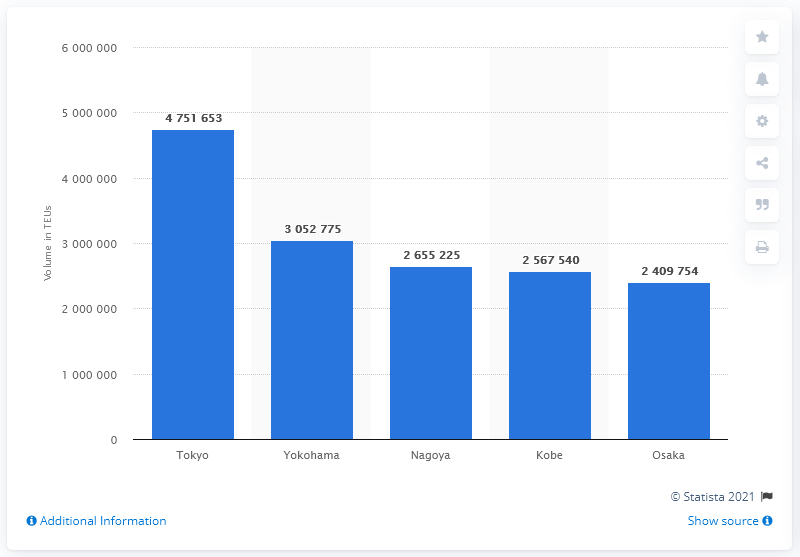

In [67]:
test_dataset[0][1]['content'][0]['image']

### Smaller batch output

In [69]:
output = generate_text_from_sample(model, processor, test_dataset[0])
print(output)

 1. **Graph description**:
"The bar chart illustrates the volume of container-handling ports in Japan in 2012, measured in TEUs (Twenty-foot Equivalent Units). The ports are listed from Tokyo to Osaka, with Tokyo being the largest port in terms of TEUs."

2. **Body paragraphs**:

**Paragraph 1**:
"Tokyo is the largest port in Japan, with a volume of 4,751,653 TEUs in 2012. This volume is significantly higher than the other ports, indicating Tokyo's dominance in the container-handling sector. Yokohama follows closely, with a volume of 3,052,775 TEUs, which is still considerably higher than Nagoya's volume of 2,655,225 TEUs."

**Paragraph 2**:
"Nagoya and Kobe are the next two largest ports, with volumes of 2,655,225 TEUs and 2,567,540 TEUs respectively. These volumes are lower than Tokyo and Yokohama, but still substantial, reflecting their importance in the Japanese shipping industry. Osaka, the smallest port in the list, has a volume of 2,409,754 TEUs, which is also lower than the oth

### Bigger batch output

In [83]:
output = generate_text_from_sample(model, processor, test_dataset[0])
print(output)

 1. <Describe a graph>:
"The bar chart illustrates the volume of container-handling ports in Japan in 2012, measured in TEUs (Twenty-foot Equivalent Units). The data is presented for five different ports: Tokyo, Yokohama, Nagoya, Kobe, and Osaka."

2. <Find the key points, trends and compare data>:

Paragraph 1:
"Tokyo is the largest container-handling port in Japan, with a volume of 4,751,653 TEUs in 2012. This figure is significantly higher than the other ports, indicating a substantial volume of container traffic through Tokyo. Yokohama follows closely, with a volume of 3,052,775 TEUs, highlighting its importance as a major port for container shipping."

Paragraph 2:
"Nagoya and Kobe also have substantial volumes, with Nagoya's volume at 2,655,225 TEUs and Kobe's at 2,567,540 TEUs. These figures suggest that Nagoya and Kobe are important ports for container shipping, although they are slightly less significant than Tokyo and Yokohama. Osaka, the fifth port, has a volume of 2,409,754